# **Dog Breed Classifier**

## Importing Libraries and Dependencies

In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix
import multiprocessing as mp

import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau, LambdaCallback
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S, preprocess_input 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, BatchNormalization, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import *
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import load_model

from PIL import Image
import xml.etree.ElementTree as ET

## Dataset Directories
- **Data Directory**: Path to the main dataset containing images.
- **Annotations Directory**: Path to the XML annotations for the dataset.
- **Working Images Directory**: Path to the working directory where images will be processed or stored during training.

In [4]:
data_dir = "/kaggle/input/stanford-dogs-dataset/images/Images/"
annotations_dir = "/kaggle/input/stanford-dogs-dataset/annotations/Annotation/"
images_dir = "/kaggle/working/images/"

## Cropping Images

Cropping the images to focus on the annotated regions (bounding boxes). The cropped images are saved in a new working directory for further preprocessing and training.



In [5]:
%%time
%system rm -rf $images_dir
%system mkdir $images_dir

def save_img(path, annotation, newpath):
    tree = ET.parse(annotation)
    xmin = int(tree.getroot().findall('.//xmin')[0].text)
    xmax = int(tree.getroot().findall('.//xmax')[0].text)
    ymin = int(tree.getroot().findall('.//ymin')[0].text)
    ymax = int(tree.getroot().findall('.//ymax')[0].text)
    image = Image.open(path)
    image = image.crop((xmin, ymin, xmax, ymax))
    image = image.convert('RGB')
    image.save(newpath)

def crop_images():
    breeds = os.listdir(data_dir)
    annotations = os.listdir(annotations_dir)

    print('Breeds: ', len(breeds), 'Annotations: ', len(annotations))
    total_images = 0

    for breed in breeds:
        new_breed='_'.join(breed.split('-')[1:])
        dir_list = os.listdir(data_dir + breed)
        annotations_dir_list = os.listdir(annotations_dir + breed)
        img_list = [data_dir + breed + '/' + i for i in dir_list]
        os.makedirs(images_dir + new_breed)

        for file in img_list:
            annotation_path = annotations_dir + breed + '/' + os.path.basename(file[:-4])
            newpath = images_dir + new_breed + '/' + os.path.basename(file)
            save_img(file, annotation_path, newpath)
            total_images += 1
    
    print("Total images cropped", total_images)

crop_images()

Breeds:  120 Annotations:  120
Total images cropped 20580
CPU times: user 42.9 s, sys: 6.96 s, total: 49.8 s
Wall time: 5min 36s


## Data Augmentation and Dataset Preparation
### **Data Augmentation**
-  **Rotation**: Randomly rotates images.
-  **Width Shift**: Shifts the image horizontally.
-  **Height Shift**: Shifts the image vertically.
-  **Shear**: Applies random shearing transformations.
-  **Zoom**: Zooms in or out.
-  **Brightness Adjustment**: Adjusts the brightness of images.
-  **Horizontal Flip**: Randomly flips images horizontally.
-  **Validation Split**
### **Dataset Preparation**
- Two data generators are created from the augmented dataset:
1. **Training Generator**  
2. **Validation/Test Generator**

In [8]:
datagen=ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    validation_split=0.2, 
    preprocessing_function=preprocess_input
)
train_generator=datagen.flow_from_directory(
        images_dir,
        target_size=(300, 300),
        batch_size=64,
        class_mode='categorical',
        shuffle=True,
        seed=42,
        subset="training"
)

test_generator=datagen.flow_from_directory(
        images_dir,
        target_size=(300, 300),
        batch_size=64,
        class_mode='categorical',
        shuffle=False,
        seed=42,
        subset="validation"
)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [5]:
train_generator.class_indices

{'Afghan_hound': 0,
 'African_hunting_dog': 1,
 'Airedale': 2,
 'American_Staffordshire_terrier': 3,
 'Appenzeller': 4,
 'Australian_terrier': 5,
 'Bedlington_terrier': 6,
 'Bernese_mountain_dog': 7,
 'Blenheim_spaniel': 8,
 'Border_collie': 9,
 'Border_terrier': 10,
 'Boston_bull': 11,
 'Bouvier_des_Flandres': 12,
 'Brabancon_griffon': 13,
 'Brittany_spaniel': 14,
 'Cardigan': 15,
 'Chesapeake_Bay_retriever': 16,
 'Chihuahua': 17,
 'Dandie_Dinmont': 18,
 'Doberman': 19,
 'English_foxhound': 20,
 'English_setter': 21,
 'English_springer': 22,
 'EntleBucher': 23,
 'Eskimo_dog': 24,
 'French_bulldog': 25,
 'German_shepherd': 26,
 'German_short_haired_pointer': 27,
 'Gordon_setter': 28,
 'Great_Dane': 29,
 'Great_Pyrenees': 30,
 'Greater_Swiss_Mountain_dog': 31,
 'Ibizan_hound': 32,
 'Irish_setter': 33,
 'Irish_terrier': 34,
 'Irish_water_spaniel': 35,
 'Irish_wolfhound': 36,
 'Italian_greyhound': 37,
 'Japanese_spaniel': 38,
 'Kerry_blue_terrier': 39,
 'Labrador_retriever': 40,
 'Lakelan

# Visualizing a Random Training Image

/kaggle/working/images/Irish_wolfhound/n02090721_2340.jpg


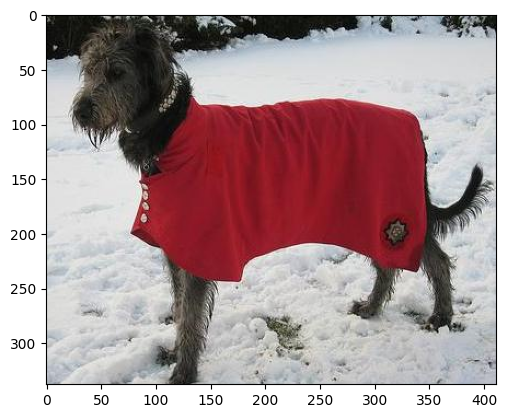

In [6]:
img = train_generator.filepaths[np.random.randint(low=0, high=train_generator.samples)]
print(img)
img = mpimg.imread(img)
plt.imshow(img)

# Setting Up Callbacks for Model Training
## **Callback Details**

1. **ModelCheckpoint**  
   - Saves the best-performing model based on validation accuracy.  
2. **TensorBoard**  
   - Logs training metrics for visualization using TensorBoard.  
3. **LambdaCallback**  
   - Customizes behavior at specific stages of training.  
4. **EarlyStopping**  
   - Stops training early if the validation accuracy stops improving.  
5. **ReduceLROnPlateau**  
   - Reduces the learning rate if the validation accuracy plateaus.  

In [7]:
checkpoint = ModelCheckpoint('dog_breed_classifier.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False)

tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    learning_rate = K.eval(model.optimizer.learning_rate)
    message = f"End of epoch {epoch}. Learning rate: {learning_rate}"
    os.system(f'echo {message}')

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(model.optimizer.learning_rate))
    
def train_begin(logs):
    os.system("echo Beginning training")

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=.0001,
                          patience=20,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                             factor=np.sqrt(.1),
                             patience=5,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=1e-7)

lambdacb = LambdaCallback(
           on_epoch_begin=epoch_begin,
           on_epoch_end=epoch_end,
           on_train_begin=train_begin
)

# Setting Up the Base Model: EfficientNetV2S
Use a pre-trained model as the foundation for our custom neural network. For this project, I use **EfficientNetV2S**, which is pre-trained on the ImageNet dataset.

In [13]:
base_model = EfficientNetV2S(include_top=False, weights='imagenet', input_shape=(300, 300, 3))
base_model.trainable=False
for layer in base_model.layers[-5:]:
    layer.trainable=True

# Building the Custom Dog Breed Classifier Model

Define a custom neural network model on top of the **EfficientNetV2S** base model for classifying dog breeds. This model is designed to process features extracted by the base model and output predictions for 120 dog breeds.

In [14]:
model=Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(rate = .2),
    BatchNormalization(),
    Dense(1024, activation='relu',  kernel_initializer=glorot_uniform(42), bias_initializer='zeros'),
    Dropout(rate = .2),
    BatchNormalization(),
    Dense(512, activation='relu',  kernel_initializer=glorot_uniform(42), bias_initializer='zeros'),
    Dropout(rate = .2),
    BatchNormalization(),
    Dense(120, activation='softmax',  kernel_initializer='random_uniform', bias_initializer='zeros')
])

# Model Summary

In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-s (Functional)        │ (None, 10, 10, 1280)        │      20,331,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 120)                 │          61,560 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,240,728 (84.84 MB)

 Trainable params: 2,233,976 (8.52 MB)

 Non-trainable params: 20,006,752 (76.32 MB)

# Compiling the Model

In [16]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Training the Model

In [17]:
%%time
history = model.fit(train_generator,
                   validation_data=test_generator,
                   epochs=100,
                   callbacks=[reducelr, earlystop, lambdacb, tensorboard, checkpoint]
                  )

Learning rate:  1e-04
Epoch 1/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4835 - loss: 3.0354
Epoch 1: val_accuracy improved from -inf to 0.91282, saving model to dog_breed_classifier.keras
258/258 ━━━━━━━━━━━━━━━━━━━━ 527s 2s/step - accuracy: 0.4844 - loss: 3.0310 - val_accuracy: 0.9128 - val_loss: 0.7882 - learning_rate: 1.0000e-04
Learning rate:  1e-04
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8955 - loss: 0.6052
Epoch 2: val_accuracy improved from 0.91282 to 0.92043, saving model to dog_breed_classifier.keras
258/258 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - accuracy: 0.8955 - loss: 0.6050 - val_accuracy: 0.9204 - val_loss: 0.3015 - learning_rate: 1.0000e-04
Learning rate:  1e-04
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9026 - loss: 0.4225
Epoch 3: val_accuracy did not improve from 0.92043
258/258 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - accuracy: 0.9026 - loss: 0.4224 - val_accuracy: 0.9180 - val_loss: 0.2923 - learning_rate: 1.0

# Accuracy Visualization
The accuracy trends for both training and validation datasets.

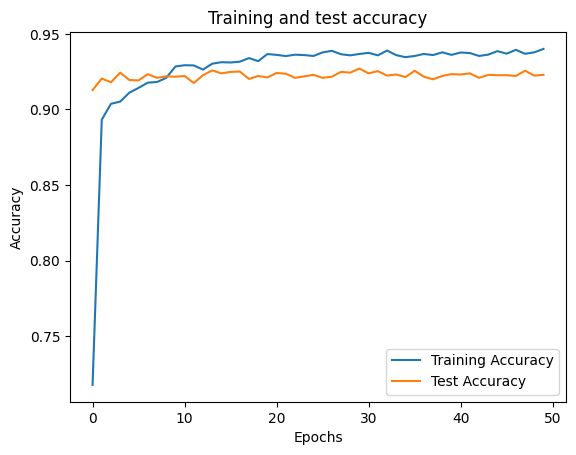

In [18]:
plt.title('Training and test accuracy')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss Visualization
The loss trends for both training and validation datasets.

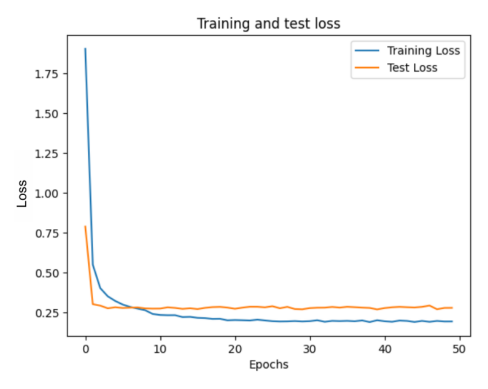

In [ ]:
plt.title('Training and test loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Saving Training History

In [20]:
import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Making Predictions

In [11]:
predictions = model.predict(test_generator)  
print(predictions)

64/64 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step
[[9.99476016e-01 1.45632998e-06 3.68219503e-06 ... 4.13924499e-06
  6.85847999e-06 1.57585350e-06]
 [9.99162912e-01 2.43865748e-06 8.09938410e-06 ... 4.22748826e-06
  3.53406222e-06 3.38064615e-06]
 [9.99718368e-01 1.11458678e-06 2.97855627e-06 ... 1.51349934e-06
  1.95204052e-06 1.40356781e-06]
 ...
 [2.31679542e-06 5.80983851e-06 9.69899847e-05 ... 2.00842783e-06
  1.88074125e-06 9.90078926e-01]
 [8.17405544e-06 1.74493962e-05 4.12336463e-04 ... 1.97670252e-05
  1.43132938e-05 6.77748442e-01]
 [5.16883847e-05 1.37481737e-04 3.06989619e-04 ... 4.14130627e-05
  1.04511724e-04 3.54440302e-01]]


In [12]:
predictions.shape

(4072, 120)

# Evaluation on Training Data


In [25]:
train_loss, train_accuracy = model.evaluate(train_generator, verbose=1)
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_accuracy}")


258/258 ━━━━━━━━━━━━━━━━━━━━ 358s 1s/step - accuracy: 0.9569 - loss: 0.1217
Train Loss: 0.1193857192993164
Train Accuracy: 0.9580809473991394


# Evaluation on Testing Data


In [20]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


64/64 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9236 - loss: 0.2835
Test Loss: 0.2840017080307007
Test Accuracy: 0.9228880405426025


# Classification Report
- Precision
- Recall
- F1-Score
- Support

In [17]:
y = np.argmax(predictions, axis=1)
cr = classification_report(y_true=test_generator.classes, y_pred=y, target_names=test_generator.class_indices)
print(cr)

                                precision    recall  f1-score   support

                  Afghan_hound       1.00      0.96      0.98        47
           African_hunting_dog       1.00      1.00      1.00        33
                      Airedale       0.93      0.97      0.95        40
American_Staffordshire_terrier       0.80      0.88      0.84        32
                   Appenzeller       0.88      0.70      0.78        30
            Australian_terrier       0.94      0.85      0.89        39
            Bedlington_terrier       1.00      1.00      1.00        36
          Bernese_mountain_dog       0.95      0.98      0.97        43
              Blenheim_spaniel       1.00      1.00      1.00        37
                 Border_collie       0.74      0.93      0.82        30
                Border_terrier       0.97      1.00      0.99        34
                   Boston_bull       0.90      1.00      0.95        36
          Bouvier_des_Flandres       0.93      0.93      0.93  

# Confusion Matrix

In [18]:
print("Confusion Matrix:")
cm=confusion_matrix(y_true=test_generator.classes, y_pred=y)
print(cm)

Confusion Matrix:
[[45  0  0 ...  0  0  0]
 [ 0 33  0 ...  0  0  0]
 [ 0  0 39 ...  0  0  0]
 ...
 [ 0  0  0 ... 28  0  0]
 [ 0  0  0 ...  0 33  0]
 [ 0  0  1 ...  0  0 27]]


Confusion Matrix


<Axes: >

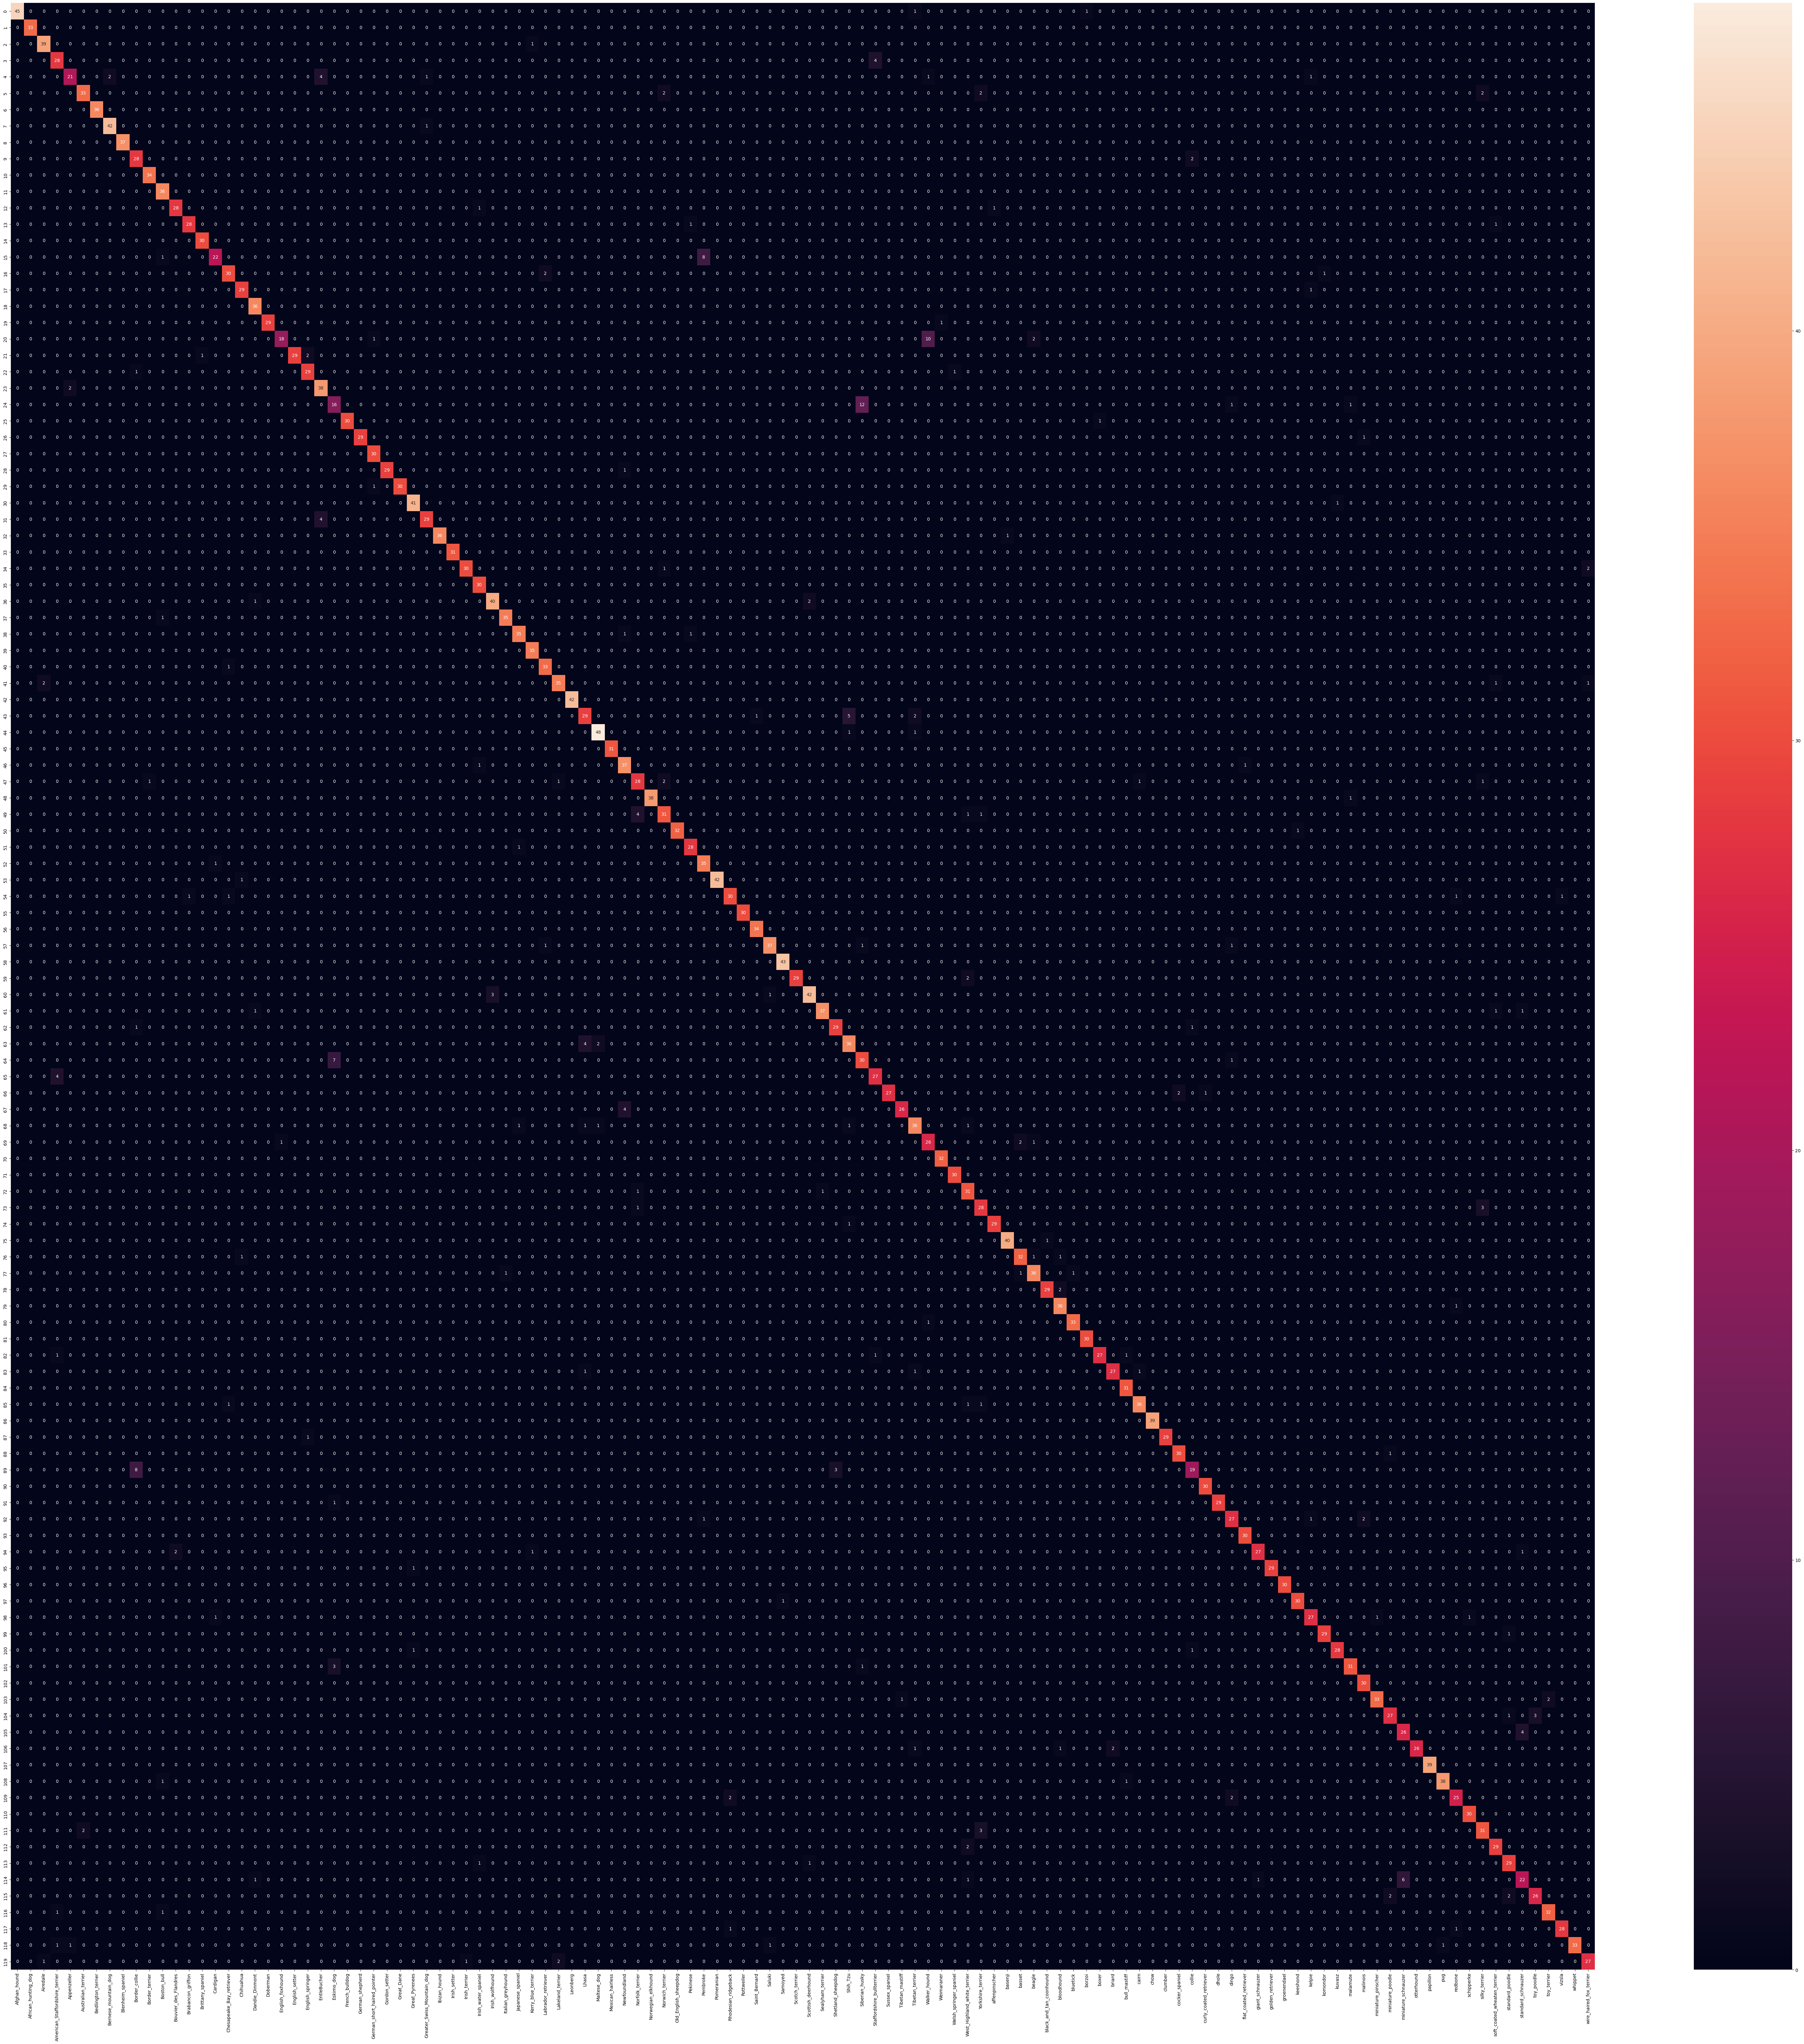

In [19]:
print('Confusion Matrix')
df = pd.DataFrame(cm, columns=test_generator.class_indices)
plt.figure(figsize=(80,80))
sns.heatmap(df, annot=True)